## Testing out data preprocessing functions 

In [286]:
from matplotlib import pyplot as plt

In [287]:
from data.data_preprocessing import *

In [288]:
from evaluate_results import *
from GCN_utils import *

In [289]:
import typhon

In [290]:
import imageio
import os

In [8]:
#assume rates for 15% PMT PC now. 
#TODO: must fix rates to right PC. 
all_rates = {
    # 10% PMT PC and 5.0 rad cut     
    'h2o': {'core_1': 0.397,
            'core_2': .277,
            's_signal': 9e-09, #est
            'r_acc': 3.4e-08,
            'r_radio': 0.0588,
            'r_fn': 0.237,
            'r_ibdbg': 0.013,
            's_bg': 5.52e-08                 
                },
    # sims data is 20% PMT OC, 5.0 rad cut   
    'wbls': {'core_1': 0.405,
            'core_2': 0.3022,
            's_signal': 4.36e-8, #est
            'r_acc': 1.32e-08,
            'r_radio': 0.0326,
            'r_fn': 0.160,
            'r_ibdbg': 0.0198,
            's_bg': 1.8e-7                
                },
}

In [7]:
save_obj(all_rates, 'all_rates')

In [3]:
acceptances = dict(tpr = np.linspace(0,1,100), fpr = np.linspace(0,1,100))
acceptances['tpr'] = np.clip(acceptances['tpr']*1.5, 0, 1)
medium='wbls'
ml_rates = ml_roc_rates(acceptances, medium, all_rates)
s, b = get_s_and_b(**ml_rates, ncore=1)
t_anom, t_meas = get_times(s, b)

In [5]:
def quick_analysis(acceptances, medium):
    '''
    Quickly returns some plots for the H20 data given a certain roc curve.
    
    acceptances: (type: dict of fpr, tpr)
    '''
    if medium=='h2o': title_extra = r'Gd-H$_2$O'
    if medium=='wbls': title_extra = r'Gd-WbLS'
    
    for ncore in [1,2]:
        extra_title=f'16m {title_extra}, {ncore}-core signal'
        plot_times(acceptances, medium, 
                   all_rates, ncore=ncore, 
                   extra_title=extra_title)

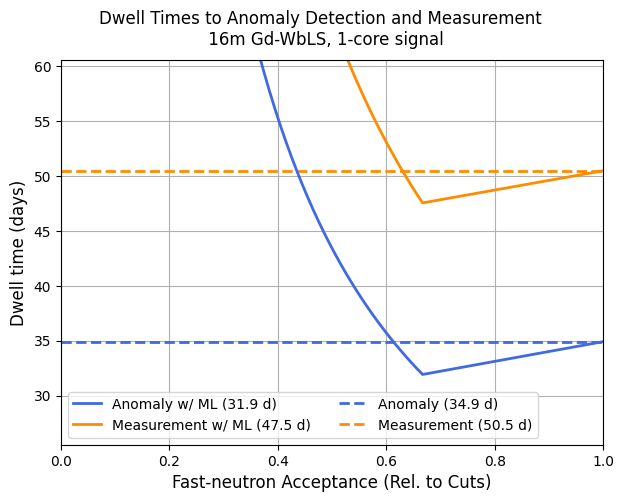

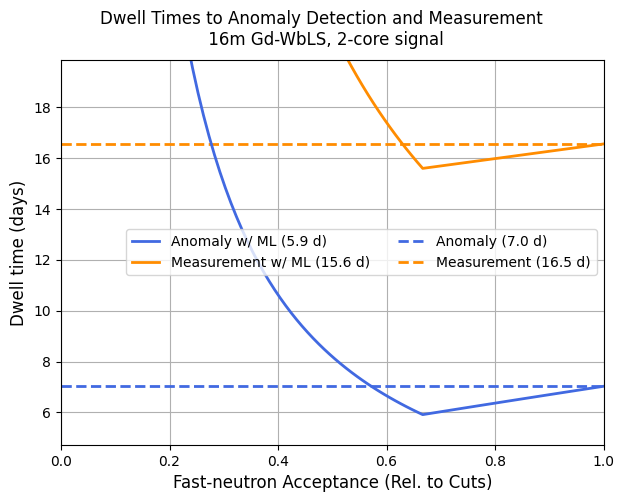

In [6]:
quick_analysis(acceptances, medium)

In [313]:
def plot_times(acceptances, 
               medium, 
               all_rates, 
               ncore=1,
               extra_title=''):
    
    ml_rates = ml_roc_rates(acceptances, medium, all_rates)
    s, b = get_s_and_b(**ml_rates, ncore=ncore)
    t_anom, t_meas = get_times(s, b)
    
    s0, b0 = get_s_and_b(**all_rates[medium], ncore=ncore)
    t_anom0, t_meas0 = get_times(s0, b0)
    
    tpr = acceptances['tpr']
    fpr = acceptances['fpr']
    #get rid of 0-multiplication mishaps 
    mask = fpr > 0. 
    fpr, tpr = fpr[mask], tpr[mask]
    
    fig, (ax, tbl) = plt.subplots(2,1, figsize=(8, 8), gridspec_kw={'height_ratios': [2, 1]})
    plt.suptitle("Dwell Times to Anomaly Detection and Measurement \n %s"%(extra_title))

    ax.plot(fpr, t_anom, 
         color='royalblue', lw=2, 
         label='Anomaly w/ ML (%.1f d)'%(np.min(t_anom))
        )

    ax.plot(fpr, t_meas, 
         color='darkorange', lw=2, 
         label='Measurement w/ ML (%.1f d)'%(np.min(t_meas))
        )
    ax.hlines(t_anom0, 0, 1, 
           color='royalblue', linestyle='--', lw=2, 
           label='Anomaly (%.1f d)'%(t_anom0)
          )
    ax.hlines(t_meas0, 0, 1, 
           color='darkorange', linestyle='--', lw=2, 
           label='Measurement (%.1f d)'%(t_meas0)
          )
    
    ax.legend(ncol=1, title=r'Dwell Time Calculations', title_fontsize=12)
    ax.set_xlabel('TODO:FIX LABEL')
    ax.set_ylabel('Dwell time (days)')    
    ax.grid()
    ax.set_xlim(0.0, 1.0)
    ax.set_ylim(min([t_anom0, min(t_anom), t_meas0, min(t_meas)])*.8,
             max([t_anom0, t_meas0])*1.2)

    # hide axes
    tbl.patch.set_visible(False)
    tbl.axis('off')
    tbl.axis('tight')


    tbl.table(cellText=data,
                      rowLabels=rows,
                      rowColours=colors,
                      colLabels=columns,
              colWidths=[0.3,0.3,0.3],
                      loc='top')
    plt.show()

In [ ]:
w = root_to_json('fastn_wbls', save=False)

In [2]:
fn = load_json_to_awkward('fastn_water')
ibd = load_json_to_awkward('ibd_water')

In [4]:
fn0, fn1 = get_paired_data(fn)
ibd0, ibd1 = get_paired_data(ibd)

In [ ]:
train, test = create_train_test_sets([[fn0, fn1], [ibd0,ibd1]], save=False, )

In [2]:
p = root_to_json('ibd_p_h2o',save=False)
n = root_to_json('ibd_n_h2o',save=False)

In [4]:
train, test = create_train_test_sets([p, n], save=False, paired_signals=False)

## Make PMT time gifs 

In [14]:
water = load_pickled_data('train_water')
wbls = load_pickled_data('train_wbls')

In [18]:
pmtxyz = load_pmt_positions(medium='wbls')

In [72]:
def data_for_cylinder_along_z(center_x,center_y,radius,height_z):
    z = np.linspace(-height_z, height_z, 50)
    theta = np.linspace(0, 2*np.pi, 50)
    theta_grid, z_grid=np.meshgrid(theta, z)
    x_grid = radius*np.cos(theta_grid) + center_x
    y_grid = radius*np.sin(theta_grid) + center_y
    return x_grid,y_grid,z_grid

Xc,Yc,Zc = data_for_cylinder_along_z(0,0,569,569)
def slice_pos(pmtxyz, return_mask=False):
    mask = np.logical_or(pmtxyz[:,0]<0, pmtxyz[:,1]>0)
    mask = np.logical_or(mask, pmtxyz[:,2]<-500)
    if return_mask: return pmtxyz[mask], mask
    else: return pmtxyz[mask]

In [ ]:
allpmts = slice_pos(pmtxyz)

In [38]:
ibdp = wbls['ev1'][wbls['y']==1]
ibdn = wbls['ev2'][wbls['y']==1]

fn0 = wbls['ev1'][wbls['y']==0]
fn1 = wbls['ev2'][wbls['y']==0]

In [103]:
def common_formatting(ax):
    ax.grid(False)
    ax.set_xlabel('x (cm)')
    ax.set_ylabel('y (cm)')
    ax.set_zlabel('z (cm)')
    # ax.plot_surface(Xc, Yc, Zc, alpha=0.05)


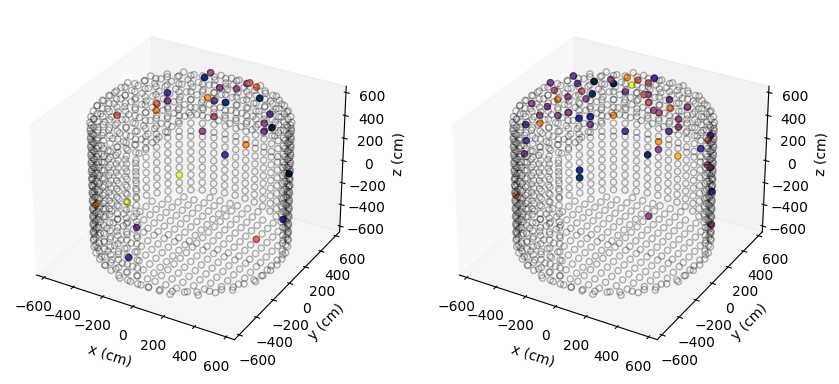

In [115]:
i = 20 # np.random.randint(0, len(ibdp))
fig = plt.figure(figsize=(10,6))
for event, plotpos in zip([ibdp, ibdn], [121,122]):
    ev = event[i]
    hitpos, mask = slice_pos(pmtxyz[ev.channel], return_mask=True)
    charge = ev.pmtcharge[mask]
    time = ev.hittime[mask]
    ax = fig.add_subplot(plotpos, projection='3d')
    ax.scatter(allpmts[:,0], allpmts[:,1], allpmts[:,2], alpha=.3, 
               facecolors='none', edgecolors='k')
    ax.scatter(hitpos[:,0], hitpos[:,1], hitpos[:,2], 
               alpha=1, c=charge, 
               cmap=plt.get_cmap("temperature")# plt.cm.temperature
              )
    common_formatting(ax)
plt.show()

In [270]:
ak.where(ibdp.n9>40)[0]

<Array [7, 18, 194, 278, ... 4927, 4934, 5054] type='51 * int64'>

## Making Gifs of PMT info

In [271]:
i=ak.where(ibdp.n9>40)[0][2]# larger signals
timeres = 20 # nanoseconds 
timebins = np.arange(640, 1000, timeres)

for ev, gif_name in zip([ibdp[i], ibdn[i]], ['ibdp', 'ibdn']):
    hitpos, mask = slice_pos(pmtxyz[ev.channel], return_mask=True)
    charge = ev.pmtcharge[mask]
    time = ev.hittime[mask]
    filenames=[]
    print('Making scatter plots')
    for i, timebin in enumerate(timebins):
        fig = plt.figure(figsize=(10,6))

        timemask = np.logical_and(time>=timebin, time<=timebin+timeres)

        charge[timemask]
        ax = fig.add_subplot(plotpos, projection='3d')
        ax.scatter(allpmts[:,0], allpmts[:,1], allpmts[:,2], alpha=.3, 
                   facecolors='none', edgecolors='k')

        ax.scatter(hitpos[timemask,0], hitpos[timemask,1], hitpos[timemask,2], 
                   alpha=1, c=charge[timemask], 
                   cmap=plt.get_cmap("temperature")# plt.cm.temperature
                  )
        if gif_name=='ibdp': title='IBD Positron Event (Total Charge: %.1f PE)'%(ev.pe)
        if gif_name=='ibdn': title='IBD Delayed n-capture Event (Total Charge: %.1f PE)'%(ev.pe)

        ax.set_title(title, pad=0)
        ax.text(-600, 700, 700, 'Time (ns): %.0f-%.0f'%(timebin-timebins[0], timebin+timeres-timebins[0]), )
        common_formatting(ax)
        filename = f'images/frame_{i}.png'
        filenames.append(filename)
        # save img
        plt.savefig(filename, transparent=False, dpi=96)
        plt.close()

    # Build GIF
    print('creating gif')
    with imageio.get_writer(f'images/{gif_name}.gif', mode='I') as writer:
        for filename in filenames:
            for i in range(1, 6): # slow it down 
                image = imageio.imread(filename)
                writer.append_data(image)
            if filename==filenames[-1]:
                for i in range(1, 10): # slow it down 
                    image = imageio.imread(filename)
                    writer.append_data(image)            
    print('gif complete')
    # Remove files
    for filename in set(filenames):
        os.remove(filename)

Making scatter plots
creating gif
gif complete
Making scatter plots
creating gif
gif complete


In [161]:
pmtxyz = load_pmt_positions()

In [5]:
pmtxyz2 = get_pmt_positions( save=False)

Processing ibd_water: Medium: h2o  Num Pmts: 2330
Processing ibd_wbls: Medium: wbls  Num Pmts: 1232


In [9]:
pmtxyz2 = load_pmt_positions(medium='wbls')

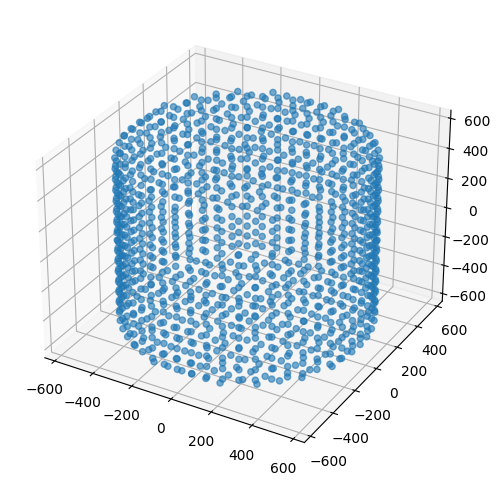

In [6]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(projection='3d')
ax.scatter(pmtxyz2['wbls'][:,0], pmtxyz2['wbls'][:,1], pmtxyz2['wbls'][:,2], alpha=.6)
plt.show()

## Distributions

In [481]:
dat1 = load_json_to_awkward('ibd_water')
dat2 = load_json_to_awkward('fastn_water')


In [482]:
dat1['r']= np.sqrt(dat1.x**2+dat1.y**2)
dat2['r']= np.sqrt(dat2.x**2+dat2.y**2)

In [483]:
ibd0, ibd1 = get_paired_data(dat1, only_dineutron=False)
fn0, fn1 = get_paired_data(dat2, only_dineutron=True)

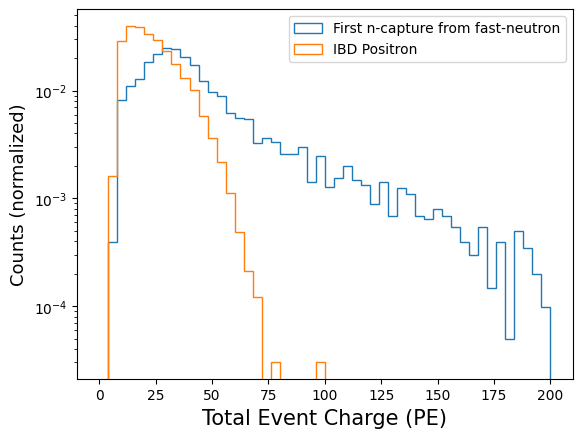

In [486]:
kw = dict(histtype='step', 
#           bins=np.logspace(0,2.5,50), 
          range=[0,200], bins=50,
          density=True)
key = 'r'
bins= plt.hist(fn0[key],  label='First n-capture from fast-neutron', **kw)
plt.hist(ibd0[key], label='IBD Positron', **kw)
plt.xlabel('Total Event Charge (PE)', fontsize=15)
plt.legend()
plt.yscale('log', )

plt.tick_params(labelsize=10)
plt.ylabel('Counts (normalized)', fontsize=13)
plt.show()

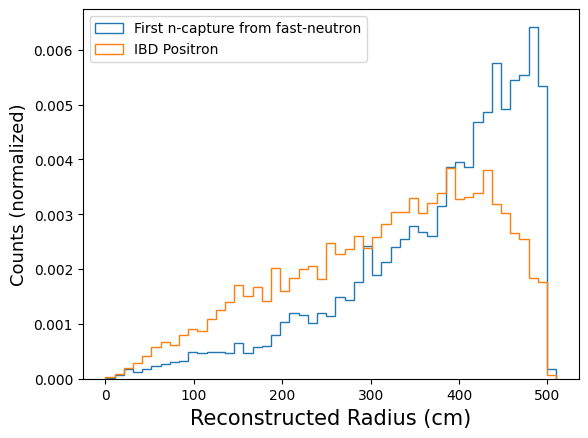

In [492]:
kw = dict(histtype='step', 
          bins=np.linspace(0,510,50),
          density=True)
key = 'r'
bins= plt.hist(fn0[key]/10,  label='First n-capture from fast-neutron', **kw)
plt.hist(ibd0[key]/10, label='IBD Positron', **kw)
plt.xlabel('Reconstructed Radius (cm)', fontsize=15)
plt.legend(loc='upper left')

plt.tick_params(labelsize=10)
plt.ylabel('Counts (normalized)', fontsize=13)
plt.show()

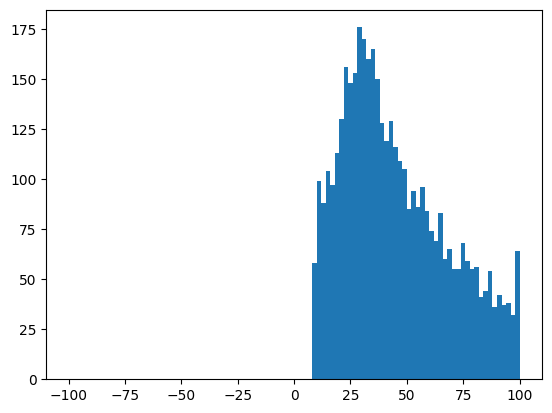

In [251]:
plt.hist(fn0.inner_hit - 0, bins=100, range=[-100,100])
plt.show()

## Make adjacency matrices 

In [291]:
tg = get_graph(max_dist=500., min_dist=0., medium='wbls')
data = GCNSeq('train_wbls', torch_graph=tg, batch_size=64, shuffle=True)


***Creating Graph...***
***Graph Created...***


In [295]:
def get_dist_matrix(medium='wbls', 
                    metric='euclidian',
):
    '''
    get a distance matrix of the PMT info. 

    medium: either "wbls" or "h2o"
    metric: 'euclidian' is the only supported one for now
    '''
    pmtxyz = load_pmt_positions(medium=medium)
    n_pmts = len(pmtxyz)

    pmtx, pmty, pmtz = pmtxyz[:,0], pmtxyz[:,1], pmtxyz[:,2]
    dist = np.zeros((n_pmts, n_pmts))
    for i, pmtpos in enumerate(pmtxyz):
        dist[i] = np.sqrt(np.sum((pmtxyz - pmtxyz[i])**2, axis=1))
    return dist 

In [296]:
dist = get_dist_matrix('wbls',)

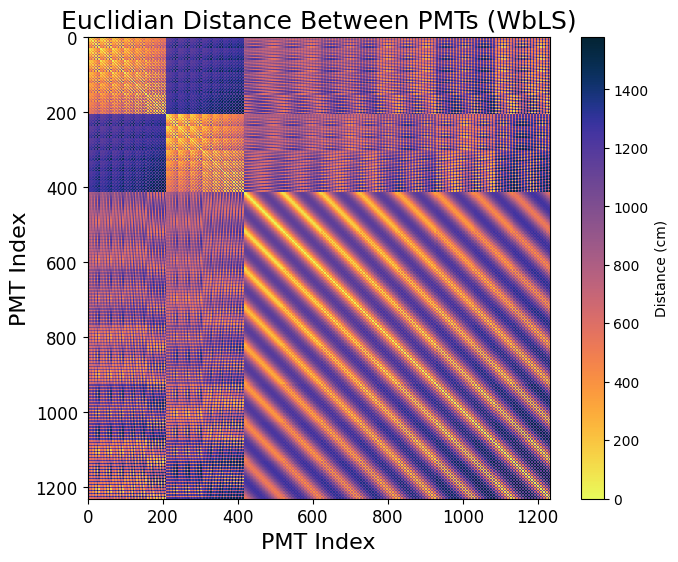

In [310]:
plt.figure(figsize=(8, 6))
plt.imshow(dist, interpolation='none', cmap=plt.get_cmap("temperature_r"))
plt.title('Euclidian Distance Between PMTs (WbLS)', fontsize=18)
plt.xlabel('PMT Index', fontsize=16)
plt.ylabel('PMT Index', fontsize=16)
plt.colorbar(label='Distance (cm)', )
plt.tick_params(axis='both', labelsize=12)
plt.show()

In [316]:
max_dist=500
edges = np.where(dist<max_dist, 1, 0)

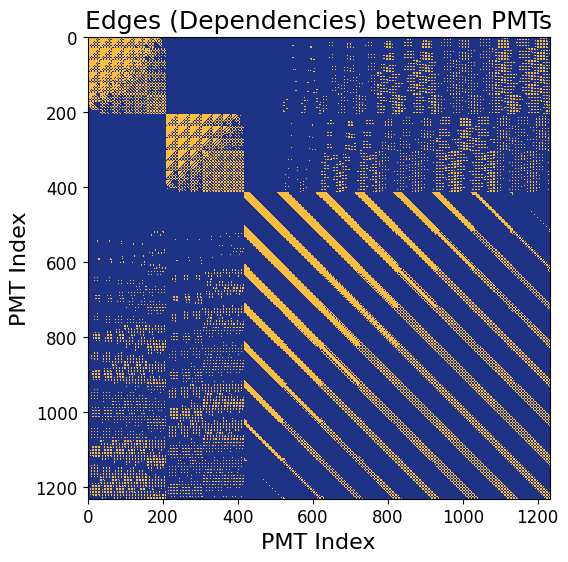

In [336]:
plt.figure(figsize=(8,6))
plt.imshow(edges,interpolation='none', cmap=plt.get_cmap("temperature"), vmin=-0.2, vmax=1.2)
plt.title('Edges (Dependencies) between PMTs', fontsize=18)
plt.xlabel('PMT Index', fontsize=16)
plt.ylabel('PMT Index', fontsize=16)
plt.tick_params(axis='both', labelsize=12)
# plt.colorbar()
plt.show()

In [337]:
#sparse graph for visualization 
max_dist=100
edges = np.where(dist<max_dist, 1, 0)

In [385]:
#sparse for visualization purposes 
G2 = get_graph(max_dist=200., min_dist=0.1, return_nx=True)

***Creating Graph...***


In [388]:
pos2 = nx.drawing.spring_layout(G2, dim=2)

In [437]:
fn0 = data.x[data.y==0]
fn = fn0[fn0.n100>200]
i=10
ev = fn[i]

In [438]:
chargenodes = np.zeros(data.n_pmts)
chargenodes[ev.channel] = ev.pmtcharge

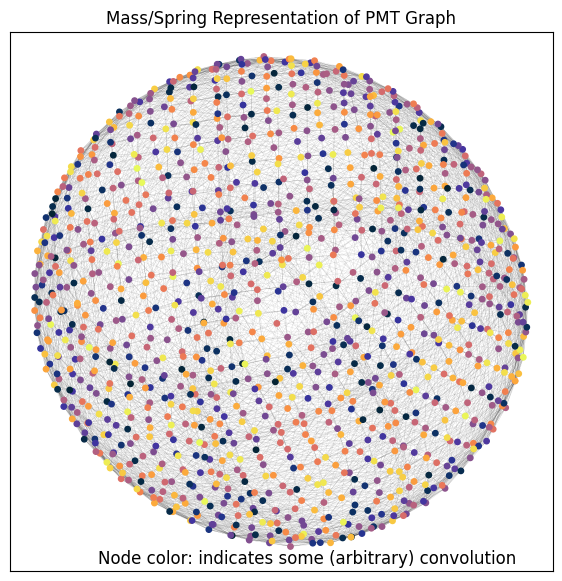

In [496]:
# plt.axes(projection='3d')
plt.figure(figsize=(7,7))
nx.draw_networkx_edges(G2, pos=pos2, width=0.1, alpha=0.3,)
nx.draw_networkx_nodes(G2, pos=pos2, node_size=15, # alpha=np.clip(chargenodes,None, 1)/1,
                       node_color= np.random.random(1232), 
                       cmap=plt.get_cmap("temperature")
                   )
plt.margins(0)
plt.title('Mass/Spring Representation of PMT Graph')
plt.annotate('Node color: indicates some (arbitrary) convolution', (-0.7,-1.07), fontsize=12)
# plt.xlim(-0.3, 0.3)
# plt.ylim(-0.3, 0.3)
plt.show()